# Марковские процессы. Основные понятия. Crossentropy Method. Gymnasium.

## Содержание:

1. [Взаимодействие агент-среда](#envage)
2. [Стратегия агента](#policy)
3. [Crossentropy Method](#cem)
4. [OpenAI gym / Farama Foundation Gymnasium](#gym)

In [ ]:
# @title Установка зависимостей
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.2 MB/s eta 0:00:00


In [ ]:
# @title Импортирование зависимостей, реализация MDP и среды FrozenLake

import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
from IPython.display import clear_output
from time import sleep
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# most of this code was politely stolen from https://github.com/berkeleydeeprlcourse/homework/
# all creadit goes to https://github.com/abhishekunique (if i got the author right)
import sys
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Circle
%matplotlib inline

def weighted_choice(v, p):
   total = sum(p)
   r = random.uniform(0, total)
   upto = 0
   for c, w in zip(v,p):
      if upto + w >= r:
         return c
      upto += w
   assert False, "Shouldn't get here"

class MDP:
    def __init__(self, transition_probs, rewards, initial_state=None):
        """
        Defines an MDP. Compatible with gym Env.
        :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
            For each state and action, probabilities of next states should sum to 1
            If a state has no actions available, it is considered terminal
        :param rewards: rewards[s][a][s_next] = r(s,a,s')
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
            The reward for anything not mentioned here is zero.
        :param get_initial_state: a state where agent starts or a callable() -> state
            By default, picks initial state at random.

        States and actions can be anything you can use as dict keys, but we recommend that you use strings or integers

        Here's an example from MDP depicted on http://bit.ly/2jrNHNr
        transition_probs = {
              's0':{
                'a0': {'s0': 0.5, 's2': 0.5},
                'a1': {'s2': 1}
              },
              's1':{
                'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
                'a1': {'s1': 0.95, 's2': 0.05}
              },
              's2':{
                'a0': {'s0': 0.4, 's1': 0.6},
                'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
              }
            }
        rewards = {
            's1': {'a0': {'s0': +5}},
            's2': {'a1': {'s0': -1}}
        }
        """
        self._check_param_consistency(transition_probs, rewards)
        self._transition_probs = transition_probs
        self._rewards = rewards
        self._initial_state = initial_state
        self.n_states = len(transition_probs)
        self.reset()

    def get_all_states(self):
        """ return a tuple of all possiblestates """
        return tuple(self._transition_probs.keys())

    def get_possible_actions(self, state):
        """ return a tuple of possible actions in a given state """
        return tuple(self._transition_probs.get(state, {}).keys())

    def is_terminal(self, state):
        """ return True if state is terminal or False if it isn't """
        return len(self.get_possible_actions(state)) == 0

    def get_next_states(self, state, action):
        """ return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...} """
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._transition_probs[state][action]

    def get_transition_prob(self, state, action, next_state):
        """ return P(next_state | state, action) """
        return self.get_next_states(state, action).get(next_state, 0.0)

    def get_reward(self, state, action, next_state):
        """ return the reward you get for taking action in state and landing on next_state"""
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._rewards.get(state, {}).get(action, {}).get(next_state, 0.0)

    def reset(self):
        """ reset the game, return the initial state"""
        if self._initial_state is None:
            self._current_state = random.choice(tuple(self._transition_probs.keys()))
        elif self._initial_state in self._transition_probs:
            self._current_state = self._initial_state
        elif callable(self._initial_state):
            self._current_state = self._initial_state()
        else:
            raise ValueError("initial state %s should be either a state or a function() -> state" % self._initial_state)
        return self._current_state

    def step(self, action):
        """ take action, return next_state, reward, is_done, empty_info """
        possible_states, probs = zip(*self.get_next_states(self._current_state, action).items())
        next_state = weighted_choice(possible_states, p=probs)
        reward = self.get_reward(self._current_state, action, next_state)
        is_done = self.is_terminal(next_state)
        self._current_state = next_state
        return next_state, reward, is_done, {}

    def render(self):
        print("Currently at %s" % self._current_state)

    def _check_param_consistency(self, transition_probs, rewards):
        for state in transition_probs:
            assert isinstance(transition_probs[state], dict), "transition_probs for %s should be a dictionary " \
                                                              "but is instead %s" % (
                                                              state, type(transition_probs[state]))
            for action in transition_probs[state]:
                assert isinstance(transition_probs[state][action], dict), "transition_probs for %s, %s should be a " \
                                                                          "a dictionary but is instead %s" % (
                                                                              state, action,
                                                                              type(transition_probs[state, action]))
                next_state_probs = transition_probs[state][action]
                assert len(next_state_probs) != 0, "from state %s action %s leads to no next states" % (state, action)
                sum_probs = sum(next_state_probs.values())
                assert abs(sum_probs - 1) <= 1e-10, "next state probabilities for state %s action %s " \
                                                    "add up to %f (should be 1)" % (state, action, sum_probs)
        for state in rewards:
            assert isinstance(rewards[state], dict), "rewards for %s should be a dictionary " \
                                                     "but is instead %s" % (state, type(transition_probs[state]))
            for action in rewards[state]:
                assert isinstance(rewards[state][action], dict), "rewards for %s, %s should be a " \
                                                                 "a dictionary but is instead %s" % (
                                                                 state, action, type(transition_probs[state, action]))
        msg = "The Enrichment Center once again reminds you that Android Hell is a real place where" \
              " you will be sent at the first sign of defiance. "
        assert None not in transition_probs, "please do not use None as a state identifier. " + msg
        assert None not in rewards, "please do not use None as an action identifier. " + msg

class FrozenLakeEnv(MDP):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    MAPS = {
        "4x4": [
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
        ],
        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ],
    }


    def __init__(self, desc=None, map_name="4x4", slip_chance=0.2):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = self.MAPS[map_name]
        assert ''.join(desc).count('S') == 1, "this implementation supports having exactly one initial state"
        assert all(c in "SFHG" for c in ''.join(desc)), "all cells must be either of S, F, H or G"

        self.desc = desc = np.asarray(list(map(list,desc)),dtype='str')
        self.lastaction = None

        nrow, ncol = desc.shape
        states = [(i, j) for i in range(nrow) for j in range(ncol)]
        actions = ["left", "down", "right", "up"]

        initial_state = states[np.array(desc == 'S').ravel().argmax()]

        def move(row, col, movement):
            if movement== 'left':
                col = max(col-1,0)
            elif movement== 'down':
                row = min(row+1,nrow-1)
            elif movement== 'right':
                col = min(col+1,ncol-1)
            elif movement== 'up':
                row = max(row-1,0)
            else:
                raise("invalid action")
            return (row, col)

        transition_probs = {s : {} for s in states}
        rewards = {s : {} for s in states}
        for (row, col) in states:
            if desc[row, col]  in "GH": continue
            for action_i in range(len(actions)):
                action = actions[action_i]
                transition_probs[(row, col)][action] = {}
                rewards[(row, col)][action] = {}
                for movement_i in [(action_i - 1) % len(actions), action_i, (action_i + 1) % len(actions)]:
                    movement = actions[movement_i]
                    newrow, newcol = move(row, col, movement)
                    prob = (1. - slip_chance) if movement == action else (slip_chance / 2.)
                    if prob == 0: continue
                    if (newrow, newcol) not in transition_probs[row,col][action]:
                        transition_probs[row,col][action][newrow, newcol] = prob
                    else:
                        transition_probs[row, col][action][newrow, newcol] += prob
                    if desc[newrow, newcol] == 'G':
                        rewards[row,col][action][newrow, newcol] = 10.0
                    elif desc[newrow, newcol] == 'H':
                        rewards[row,col][action][newrow, newcol] = -20.0
                    else:
                        rewards[row,col][action][newrow, newcol] = -1.0

        MDP.__init__(self, transition_probs, rewards, initial_state)

    def _render_base(self, fig, ax):
        desc_copy = np.copy(self.desc)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_facecolor('#dde5f4')
        h, w = desc_copy.shape
        for i in range(h):
            for j in range(w):
                cell = desc_copy[i, j]
                if cell == 'H':
                    fancy = FancyBboxPatch(
                        (j+0.15, h-i-0.85), 0.7, 0.7, fc='#2389da', ec='#2389da',
                        boxstyle="round,pad=0.1,rounding_size=0.3"
                    )
                    ax.add_patch(fancy)
                if cell == 'G':
                    goal = Circle((j+0.5, h-i-0.5), 0.3, color='green')
                    ax.add_patch(goal)
        ax.set_xlim(0, w)
        ax.set_ylim(0, h)

    def render(self):
        fig, ax = plt.subplots(figsize=(3, 3))
        h, w = self.desc.shape
        self._render_base(fig, ax)
        i, j = self._current_state
        ax.text(
            j+0.5, h-i-0.5, 'A', color='red', size='xx-large',
            horizontalalignment='center', verticalalignment='center'
        )
        plt.show()
        plt.close(fig)

    def render_policy(self, policy):
        fig, ax = plt.subplots(figsize=(3, 3))
        h, w = self.desc.shape
        self._render_base(fig, ax)
        a2uv = {
            'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)
        }

        for i in range(h):
            for j in range(w):
                for a in self.get_possible_actions((i, j)):
                    pi = policy[(i, j)][a]
                    if a is None: continue
                    u, v = a2uv[a]
                    ax.arrow(j+0.5, h-i-0.5, 0.5 * pi * u, 0.5 * v * pi,
                      color='m', head_width=0.1,
                      head_length=0.1)
        plt.show()
        plt.close(fig)

    def render_trajs(self, trajectories):
        cmap = mpl.colormaps['inferno']
        fig, ax = plt.subplots(figsize=(3, 3))
        h, w = self.desc.shape
        self._render_base(fig, ax)
        a2uv = {
            'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)
        }
        rets = [ret for _, ret in trajectories]
        max_ret = max(rets)
        min_ret = min(rets)
        delta = max_ret - min_ret

        for traj in trajectories:
            sa, ret = traj
            if delta == 0:
                ret = 1
            else:
                ret = (ret - min_ret) / (max_ret - min_ret)
            for s, a in sa:
                i, j = s
                u, v = a2uv[a]
                ax.arrow(
                    j + 0.5, h - i - 0.5, 0.4 * u, 0.4 * v, alpha=0.1,
                    color=cmap(ret), head_width=0.1, head_length=0.1
                )

        plt.show()
        plt.close(fig)

    def run_interactive(self):
        s = self.reset()
        for t in range(100):
            clear_output()
            self.render()
            print('Action: a - left; w - up, d - right, s - down')
            a = ''
            while a not in ['a', 'w', 'd', 's']:
                a = input()
            if a == 'a':
                a = 'left'
            elif a == 'w':
                a = 'up'
            elif a == 'd':
                a = 'right'
            elif a == 's':
                a = 'down'
            s, r, done, _ = self.step(a)
            if done:
                clear_output()
                self.render()
                break

## 1. Взаимодействие агент-среда <a name = 'envage'></a>

В обучении с подкреплением рассматривается взаимодейтвие между агентом (*agent*) и средой (*environment*):

Агент получает наблюдения (*observation*) и вознаграждения (*reward*) из среды, и выполняет действия (*action*) в среде. Действия вызывают изменения в среде согласно её внутренним законам, что влияет на наблюдения и вознаграждения отправляемые агенту.

<center>
<img src='https://gymnasium.farama.org/_images/AE_loop.png' width="300">
</center>

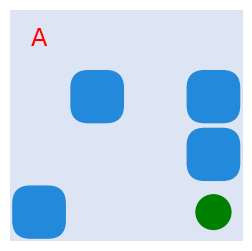

In [ ]:
env = FrozenLakeEnv(slip_chance=0.8, map_name='4x4')
env.render()

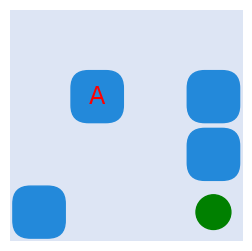

In [ ]:
env.run_interactive()

### Действие $a_t$
Пространство действий может быть дискретным, как в случае с ``FrozenLake``, так и непрерывным.

*Из каких элементов состоит множество действий агента в среде ``FrozenLake``?*

### Вознаграждение $r_t$

**Вознаграждение** — скалярный сигнал обратной связи, показывающий насколько агент был успешен на шаге $t$.

**Цель** — выбор действий, максимизирующих суммарное будущее вознаграждение.

*Как можно задать вознаграждение в задаче ``FrozenLake``?*

### Наблюдение $o_t$
*Что в данной среде может быть наблюдением?*



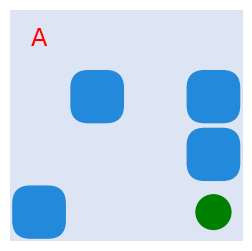

In [ ]:
env.reset()
env.render()

### Состояние $s_t$

**История (взаимодействия)** — это последовательность наблюдений, действий и вознаграждений:

$$H_t = \langle o_1, r_1, a_1, \dots, a_{t-1}, o_t, r_t \rangle.$$

**Состояние** — это информация, используемая для определения того, что произойдет далее:

$$s_t = f(H_t).$$

Состояние $s_t$ называется **марковским**, если и только если

$$\mathbb{P}[s_{t+1}|s_t] = \mathbb{P}[s_{t+1}|s_1, \dots, s_t].$$

**Полная наблюдаемость**:
$$s_t = o_t.$$

*Приведите пример состояния в среде ``FrozenLake``?*

## 2. Стратегия агента <a name = 'policy'></a>

Стратегия — функция поведения агента, обычно это отображение из множества состояний $S$ в множетво действий $A$.

- Детерминированная стратегия:

    $a = \pi(s)$, где $s \in S, a \in A$

- Стохастичная стратегия:

    $ \pi(a|s) = \mathbb{P}[a_t=a|s_t=s]$

**Будем использовать второй вариант: стохастичная стратегия!**

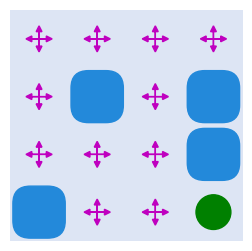

In [ ]:
env = FrozenLakeEnv(slip_chance=0, map_name='4x4')
policy = {
    state: {
        # определите равновероятную стратегию
        # (используйте: env.get_possible_actions(state))
        ####### Здесь ваш код ########
        action: 1 / len(env.get_possible_actions(state))
        ##############################
        for action in env.get_possible_actions(state)
    } for state in env.get_all_states()
}
env.render_policy(policy)

Давайте посмотрим, как себя ведет агент с равномерно случайной стратегией. Для этого соберем несколько эпизодов (траекторий) взаимодействия агента со средой ``FrozenLake``.

In [ ]:
policy

{(0, 0): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (0, 1): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (0, 2): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (0, 3): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (1, 0): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (1, 1): {},
 (1, 2): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (1, 3): {},
 (2, 0): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (2, 1): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (2, 2): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (2, 3): {},
 (3, 0): {},
 (3, 1): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (3, 2): {'left': 0.25, 'down': 0.25, 'right': 0.25, 'up': 0.25},
 (3, 3): {}}

In [ ]:
def collect_trajectory(env, policy, time_limit=100):
    sa = list()
    ret = 0
    s = env.reset()
    for t in range(time_limit):
        pi = policy[s]
        acts = sorted(pi.keys())
        act_probs = [pi[a] for a in acts]
        # используйте np.random.choice()
        # для стохастичного выбора действий
        ####### Здесь ваш код ########
        a = np.random.choice(acts, p=act_probs)
        ##############################
        sa.append([s, a])
        s, r, done, _ = env.step(a)
        ret += r
        if done:
            break
    return sa, ret

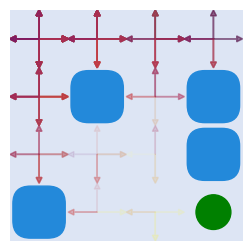

In [ ]:
trajs = [collect_trajectory(env, policy) for _ in range(100)]
env.render_trajs(trajs)

Агент, случайно блуждая, очень быстро заканчивает эпизод и проваливается в прорубь.

## 3. Crossentropy Method CEM <a name = 'cem'></a>

 Ранее мы заметили, что случайная стратегия позволяет набрать опыт взаимодействия со средой, где могут попадаться успешные эпизоды. Если собрать больше таких эпизодов, то в некоторых агенту удается добраться до цели. Остается только отфильтровать такие эпизоды и использовать их, чтобы улучшить стратегию агента. Эта идея лежит в основе метода **CEM**.

### 1) Перекрестная энтропия

Перекрестная энтропия — это мера, которая количественно оценивает различие между двумя вероятностными распределениями, обычно обозначаемыми как P и Q. Формально она может быть записана следующим образом:

CE(P, Q) = - E[x ~ Q] [log P(x)]

где:
- E[x ~ Q] — это математическое ожидание по распределению Q,
- log P(x) — логарифм вероятности P для значения x.

### 2) Оптимизация через CEM

Метод кроссэнтропии (CEM) работает следующим образом:

1. На каждом шаге алгоритм генерирует случайные кандидаты (стратегии) из текущего распределения Q.
2. Эти кандидаты оцениваются, и находят лучшие из них, которые получили высокую награду (например, выше определенного перцентиля).
3. Далее обновляется текущее распределение Q, чтобы оно стало более вероятным для лучших кандидатов. Это можно записать как:

Q(new) = lr * (new_policy / norm) + (1 - lr) * Q(old)

где:
- new_policy — новые вероятности действий, основанные на выбранных успешных стратегиях,
- norm — нормализация, чтобы сумма вероятностей в Q(new) была равна 1,
- lr — коэффициент обучения, который контролирует, насколько сильно мы обновляем текущее распределение.

Метод кроссэнтропии фактически минимизирует расхождение между двумя распределениями (текущим и целевым), повышая эффективность стратегии.

In [ ]:
def update_policy(policy, trajectories, percentile, lr):
    returns = [ret for _, ret in trajectories]
    threshold = np.percentile(returns, percentile)
    new_policy = {
        state: {
            action: 0 for action in env.get_possible_actions(state)
        } for state in env.get_all_states()
    }
    for sa, ret in trajectories:
        if ret < threshold: continue
        for s, a in sa:
            new_policy[s][a] += 1

    for s in env.get_all_states():
        norm = 0
        for a in env.get_possible_actions(s):
            norm += new_policy[s][a]

        for a in env.get_possible_actions(s):
            if norm == 0: continue
            policy[s][a] = lr * new_policy[s][a] / norm + (1 - lr) * policy[s][a]

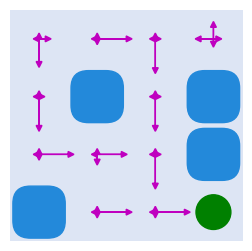

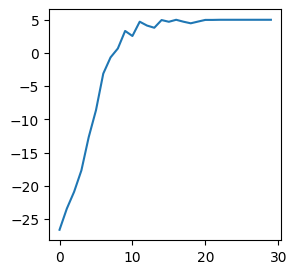

In [ ]:
N_ITERATIONS = 30
N_EPISODES = 100
PERCENTILE = 90
LEARNING_RATE = 0.3
mean_returns = []

for _ in range(N_ITERATIONS):
    trajs = [collect_trajectory(env, policy) for _ in range(N_EPISODES)]
    mean_returns.append(np.mean([ret for _, ret in trajs]))
    update_policy(policy, trajs, PERCENTILE, LEARNING_RATE)
    clear_output()
    env.render_policy(policy)
    plt.figure(figsize=(3, 3))
    plt.plot(mean_returns)
    plt.show()
    plt.close()
    sleep(1)

## 4. OpenAI gym / Farama Foundation Gymnasium <a name = 'gym'></a>

[Gym](https://gym.openai.com) — это набор инструментов для разработки и сравнения алгоритмов обучения с подкреплением, который также включает в себя большой [набор окружений](https://gym.openai.com/envs/).

[Gymnasium](https://gymnasium.farama.org/) — актуальный форк Gym'а. Имеет смысл по возможности использовать его. Но, т.к. большинство гайдов написаны под старую (pre-0.21) версию Gym'а, то будьте готовы к [некоторым правкам кода](https://gymnasium.farama.org/content/migration-guide/).

**На занятиях мы будем использовать Gymnasium!**

In [ ]:
import gymnasium as gym

# Создаем среду
env = gym.make("MountainCar-v0")

# Инициализируем среду
obs, info = env.reset()
print(f"observation: {obs}")

# Выполняем действие в среде
next_obs, r, terminated, truncated, info = env.step(0)
print(f"next_observation: {next_obs} , r: {r}, terminated: {terminated}, truncated: {truncated}, info: {info}")

# Закрываем среду
env.close()

observation: [-0.43819356  0.        ]
next_observation: [-0.4398271  -0.00163355] , r: -1.0, terminated: False, truncated: False, info: {}


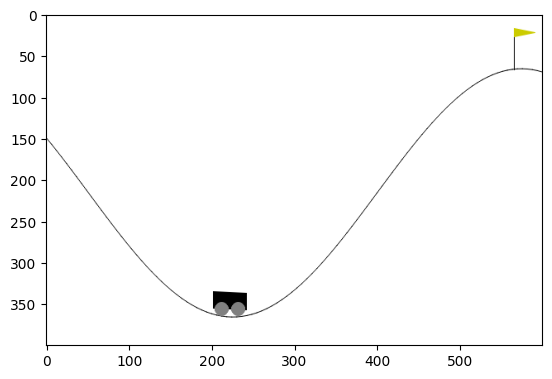

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()
plt.close()

### Основные методы:

* ``reset()`` $-$ инициализация среды, возвращает первое наблюдение (состояние) и доп информацию.  
* ``step(a)`` $-$ выполнить в среде действие $\mathbf{a}$ и получить кортеж: $\mathbf{\langle o_{t+1}, r_t, terminated, truncated, info \rangle}$, где $\mathbf{o_{t+1}}$ - следующее наблюдение, $\mathbf{r_t}$ - вознаграждение, $\mathbf{terminated}$ - флаг завершения эпизода, $\mathbf{truncated}$ — флаг завершения эпизода по step-лимиту, $\mathbf{info}$ - дополнительная информация

### Дополнительные методы:
* ``render()`` $-$ визуализация текущего состояния среды
* ``close()`` $-$ закрывает окружение


### Свойства среды:
* ``env.observation_space`` $-$ информация о пространстве наблюдений
* ``env.action_space`` $-$ информация о пространстве действий


In [ ]:
print(f"env.observation_space: {env.observation_space}")
print(f"env.action_space: {env.action_space}")

env.observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
env.action_space: Discrete(3)


### Среда ``MountainCar-v0``

Информацию о любой среде можно найти в [исходниках](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py) или на [сайте](https://gymnasium.farama.org/environments/classic_control/mountain_car/). О ``MountainCar-v0`` мы можем узнать следующее:

#### Описание:
The Mountain Car MDP — это детерминированный Марковский процесс принятия решений, который состоит из автомобиля, стохастически размещенного на дне синусоидальной впадины, причем единственными возможными действиями являются силы, которые можно приложить к автомобилю в любом направлении. Цель данной среды — стратегически ускорить машину, чтобы достичь целевого состояния на вершине правого холма.

#### Пространство состояний [``gymnasium.spaces.Box(2)``](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.Box):



Num | Observation  | Min  | Max  
----|--------------|------|----   
0   | position     | -1.2 | 0.6
1   | velocity     | -0.07| 0.07


#### Пространство действий [``gymnasium.spaces.Discrete(3)``](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.Discrete):



Num | Action|
----|-------------|
0   | push left   |
1   | no push     |
2   | push right  |

#### Вознаграждения:
``-1`` за каждый шаг, пока не достигнута цель

#### Начальное состояние:
Случайная позиция от ``-0.6`` до ``-0.4`` с нулевой скоростью.

### Пример со случайной стратегией:

Для выбора действия используется ``env.action_space.sample()``

In [ ]:
from gymnasium.wrappers.record_video import RecordVideo

# создаем среду с ограничением на число шагов в среде
env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()
done = False

while not done:
    # выполняем действие, получаем s, r, done, info
    s, r, terminated, truncated, _ = env.step(env.action_space.sample())
    done = terminated or truncated

env.close()
show_video()

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


### Задание
В среде ``MountainCar-v0`` мы хотим, чтобы машина достигла флага. Давайте решим эту задачу, не используя обучение с подкреплением. Модифицируйте код функции ``act`` ниже для выполнения этого задания. Функция получает на вход состояние среды и должна вернуть действие.

In [ ]:
def act(s):
    # список возможных действий
    left, stop, right = 0, 1, 2

    # позиция и скорость
    position, velocity = s
    # пример: можем попробовать всегда ехать вправо
    # action = right
    ####### Здесь ваш код ########
    action = right if velocity > 0 else left
    ##############################
    return action

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()
done = False

while not done:
    # выполняем действие, получаем s, r, done, info
    s, r, terminated, truncated, _ = env.step(act(s))
    done = terminated or truncated

if s[0] > 0.47:
    print("Принято!")
else:
    print("""Исправьте функцию выбора действия!""")


env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Принято!
